# Model Validation for Carbon Monoxide Column (XCO)

This Jupyter notebook describes the validation steps for the SEARS XCO CrIS ML model for Carbon Monoxide Column (XCO) prediction.

The name of the model used is "Swift EARth Science XCO CrIS ML", also known as "SEARS XCO CrIS ML", and the version used is v1.9 which at the time of this writing is the latest version of the model. The model was trained using [TROPESS](https://tropess-notes.swiftearthscience.org/intro-datasets-forward-cris-jpss-1/) data.

This code runs a test for `January 2nd, 2024` and compares the TROPESS XCO column ("Truth") with the SEARS XCO CrIS ML XCO column ("Prediction") for the same day. 

The test shows that the SEARS XCO CrIS ML model can accurately predict the Carbon Monoxide column (XCO) globally from CriS JPSS-1 / NOAA-20 radiance and geolocation data. 

## Import packages

In [12]:
%%capture

import os

# data i/o
import xarray as xr
import numpy as np
import pandas as pd

from joblib import load

# Machine Learning
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from keras.models import load_model

# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

## Select model version

In [13]:
# model version
version = 'v1.9'

## Read test data

### Read data

In [14]:
ds = xr.open_dataset('./data/TRPSYL2COCRS1FS.1/2024-01-02/tropess_cris_rad.nc')

# microwindows
x_mw = ds['x_mw'].values

# get the radiances
rad_sw = ds['rad_sw'].values
rad_mw = ds['rad_mw'].values
rad_lw = ds['rad_lw'].values

# get the wavenumber grids
wnum_lw = ds['wnum_lw'].values
wnum_mw = ds['wnum_mw'].values
wnum_sw = ds['wnum_sw'].values

# select the wavenumber range within the x_mw range
index_sw = np.where((wnum_sw >= x_mw[0, 0]) & (wnum_sw <= x_mw[0, -1]))[0]
index_mw = np.where((wnum_mw >= x_mw[0, 0]) & (wnum_mw <= x_mw[0, -1]))[0]
index_lw = np.where((wnum_lw >= x_mw[0, 0]) & (wnum_lw <= x_mw[0, -1]))[0]

# select the radiances within the x_mw range
rad_sw = rad_sw[:, index_sw]
rad_mw = rad_mw[:, index_mw]
rad_lw = rad_lw[:, index_lw]

# concatenate the radiances
rad_all = np.concatenate((rad_sw, rad_mw, rad_lw), axis=1)

### Put everything in a DataFrame 

In [15]:
df = pd.DataFrame(rad_all, columns=[f'freq_{i}' for i in range(rad_all.shape[1])])
df['sol_zen'] = ds['sol_zen'].values
df['view_ang'] = ds['view_ang'].values
df['lat'] = ds['lat'].values
df['lon'] = ds['lon'].values
df['surf_alt'] = ds['surf_alt'].values
df['x_col'] = ds['x_col'].values
df

freq_0    freq_1    freq_2    freq_3    freq_4    freq_5    freq_6  \
0      1.728163  1.877602  1.868290  1.487039  1.684189  1.831528  1.614480   
1      1.649486  1.698336  1.633244  1.305192  1.466797  1.604789  1.490178   
2      1.502273  1.681431  1.603127  1.244511  1.400010  1.578782  1.347940   
3      1.585017  1.788456  1.718454  1.324924  1.513300  1.699426  1.445408   
4      1.720866  1.889747  1.871431  1.504817  1.657643  1.841449  1.634289   
...         ...       ...       ...       ...       ...       ...       ...   
40465  0.516140  0.525526  0.510668  0.455970  0.474169  0.484743  0.489949   
40466  0.517676  0.546703  0.510474  0.460309  0.480100  0.507740  0.490774   
40467  0.389643  0.392439  0.385829  0.345680  0.364458  0.349169  0.381284   
40468  0.362302  0.374521  0.359075  0.333816  0.350586  0.353371  0.335240   
40469  0.721977  0.794511  0.727240  0.604583  0.612928  0.723280  0.624739   

         freq_7    freq_8    freq_9  ...   freq_27   freq_28   freq_29  \
0      1.712737  1.533962  1.192963  ...  1.130634  1.071487  1.139017   
1      1.549921  1.319077  1.174590  ...  0.955425  0.936192  0.961850   
2      1.441621  1.259302  0.975720  ...  0.874194  0.813178  0.886241   
3      1.541950  1.371280  1.021333  ...  0.927304  0.856228  0.955061   
4      1.700501  1.541654  1.176711  ...  1.140300  1.070431  1.134980   
...         ...       ...       ...  ...       ...       ...       ...   
40465  0.454427  0.466745  0.417149  ...  0.337447  0.339147  0.335459   
40466  0.489769  0.448977  0.439844  ...  0.346478  0.335610  0.327897   
40467  0.356691  0.326714  0.330235  ...  0.270910  0.265628  0.275966   
40468  0.349497  0.322690  0.324345  ...  0.266414  0.250868  0.253618   
40469  0.654282  0.562119  0.450953  ...  0.337577  0.346104  0.359273   

        freq_30     sol_zen   view_ang        lat        lon     surf_alt  \
0      0.981569  126.349365  10.695498 -28.976671  14.779457     0.000000   
1      0.917609  127.896027  32.346649 -28.220890  10.905661     0.000000   
2      0.761095  121.915581  41.584274 -30.538448  24.387032  1480.430786   
3      0.834249  122.145279  39.115875 -30.598688  23.613056  1201.312378   
4      0.971587  124.923309   6.004320 -29.820435  17.160793   148.928574   
...         ...         ...        ...        ...        ...          ...   
40465  0.338968   91.250351  13.073485 -65.800491  -1.297861     0.000000   
40466  0.317088   91.156967  20.751623 -65.773331  -4.446333     0.000000   
40467  0.275979   90.281052  19.819241 -66.617737  -5.267918     0.000000   
40468  0.259445   90.053825  26.098942 -66.655052  -8.386524     0.000000   
40469  0.357260   91.867027  48.364948 -63.438637 -19.670118     0.000000   

           x_col  
0      68.560249  
1      65.140305  
2      60.777603  
3      61.305073  
4      69.753883  
...          ...  
40465  38.749565  
40466  41.074181  
40467  39.520351  
40468  40.093941  
40469  42.956348  

[40470 rows x 37 columns]

## Define model inputs and outputs

The first 31 + 5 columns featuring spectral radiance values for 31 wavelengths as well as solar zenith angle, sensor view angle, latitude, longitude, and surface altitude will serve as input (X) variables. The XCO column Carbon Monoxide information serves as output (y) variable, which the model should be able to predict.

In [16]:
input_size = rad_all.shape[1] + 5

X = df.values[:, 0:input_size]
y = df.values[:, input_size:input_size+1]
X.shape, y.shape

((40470, 36), (40470, 1))

## Load the model

Load the model and the input scaler:

In [17]:
# load model
model = load_model(f'./models/{version}_model_xco_cris.keras')

# load the input scaler
input_scaler = load(f'./models/{version}_model_xco_cris_input_scaler.joblib')

## Run the model

In [18]:
%%capture

# Disable TensorFlow debugging logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

#   Level | Level for Humans | Level Description                  
#  -------|------------------|------------------------------------ 
#   0     | INFO             | [Default] Print all messages       
#   1     | WARNING          | Filter out INFO messages           
#   2     | ERROR            | Filter out INFO & WARNING messages 
#   3     | NONE             | Filter out all messages      


# scale the input
X_scaled = input_scaler.transform(X)

# make a prediction
yhat = model.predict(X_scaled)

## Calculate a few metrics

In [19]:
mae = mean_absolute_error(y, yhat)
rmse = root_mean_squared_error(y, yhat)
pearson = np.sqrt(r2_score(y, yhat))

print(f'Mean Absolute Error: {round(float(mae), 3)} ppbv')
print(f'Root Mean Squared Error: {round(float(rmse), 3)} ppbv')
print(f'Pearson Correlation Coefficient: {round(float(pearson), 3)}')

Mean Absolute Error: 3.792 ppbv
Root Mean Squared Error: 5.536 ppbv
Pearson Correlation Coefficient: 0.974


## Compare mean and standard deviation

In [20]:
print('\nEvaluation of mean and standard deviation of the estimated \nvalues of Carbon Monoxide (XCO) column compared to the actual ones: \n')

print(f'Carbon Monoxide (XCO) Column True mean: {round(float(np.mean(y)), 3)} ppbv')
print(f'Carbon Monoxide (XCO) Column Estimated mean: {round(float(np.mean(yhat)), 3)} ppbv \n')

print(f'Carbon Monoxide (XCO) Column True std: {round(float(np.std(y)), 3)} ppbv')
print(f'Carbon Monoxide (XCO) Column Estimated std: {round(float(np.std(yhat)), 3)} ppbv')


Evaluation of mean and standard deviation of the estimated 
values of Carbon Monoxide (XCO) column compared to the actual ones: 

Carbon Monoxide (XCO) Column True mean: 90.599 ppbv
Carbon Monoxide (XCO) Column Estimated mean: 91.174 ppbv 

Carbon Monoxide (XCO) Column True std: 24.556 ppbv
Carbon Monoxide (XCO) Column Estimated std: 23.689 ppbv


## Plot R Squared

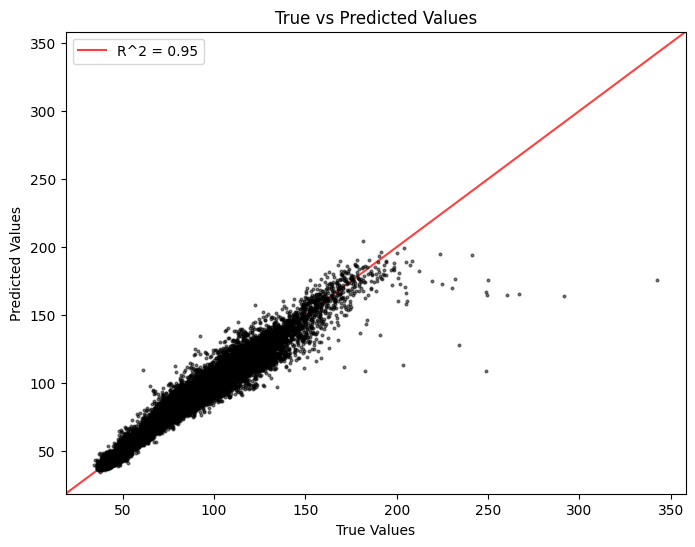

In [21]:
from sklearn.metrics import r2_score

# Calculate R-squared value
r2 = r2_score(y, yhat)

plt.figure(figsize=(8, 6))
plt.scatter(y, yhat, color='black', marker='.', s=15, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')

# Set the limits of x and y to be the same
lims = [
    np.min([plt.xlim(), plt.ylim()]),  # min of both axes
    np.max([plt.xlim(), plt.ylim()]),  # max of both axes
]

plt.xlim(lims)
plt.ylim(lims)

# Draw the diagonal line
plt.plot(lims, lims, 'r-', alpha=0.75, zorder=0, label=f'R^2 = {r2:.2f}')

# Show the legend
plt.legend()

plt.show()

## Plot Clustered R Squared

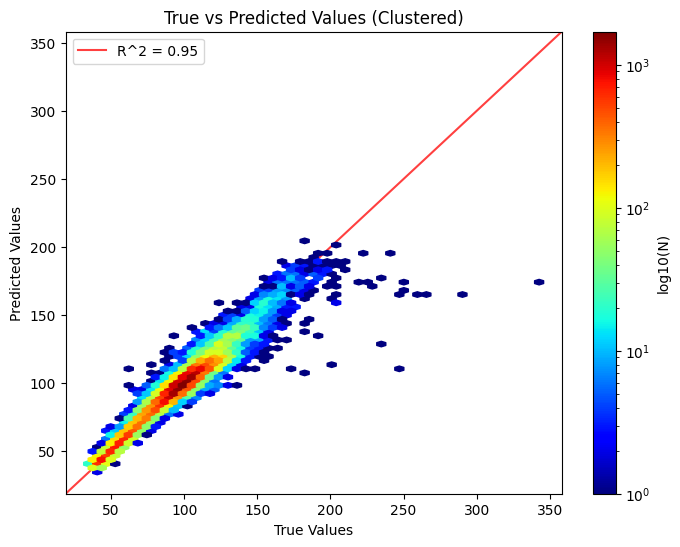

In [22]:
from matplotlib import cm

# Calculate R-squared value
r2 = r2_score(y, yhat)

plt.figure(figsize=(8, 6))
plt.hexbin(y, yhat, gridsize=50, cmap=cm.jet, bins='log')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values (Clustered)')

cb = plt.colorbar()
cb.set_label('log10(N)')

# Set the limits of x and y to be the same
lims = [
    np.min([plt.xlim(), plt.ylim()]),  # min of both axes
    np.max([plt.xlim(), plt.ylim()]),  # max of both axes
]

plt.xlim(lims)
plt.ylim(lims)

# Draw the diagonal line
plt.plot(lims, lims, 'r-', alpha=0.75, zorder=0, label=f'R^2 = {r2:.2f}')

# Show the legend
plt.legend()

plt.show()

## Plot TROPESS XCO (True Value)

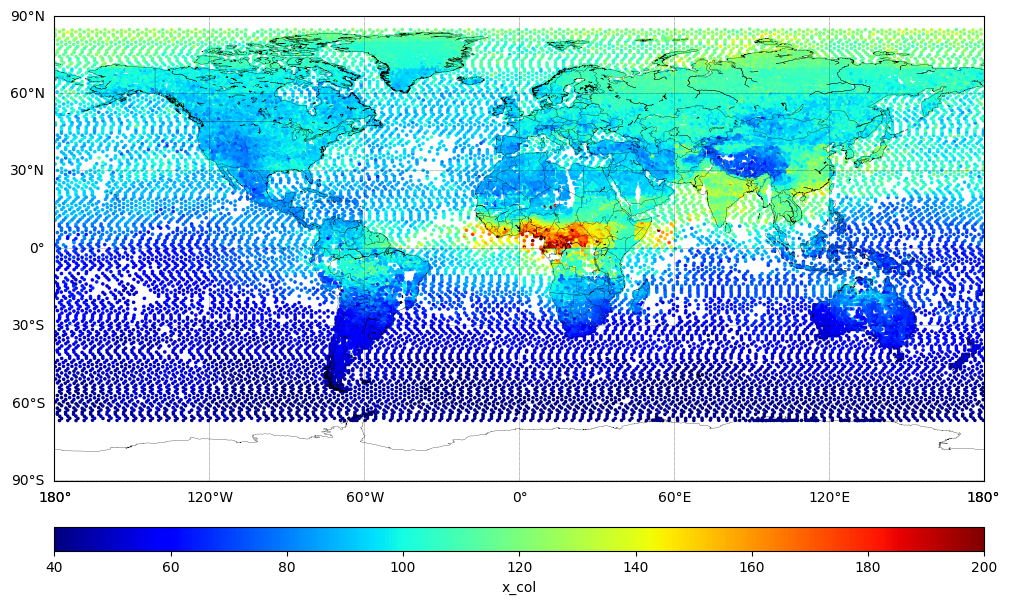

In [23]:
latitude = df['lat']
longitude = df['lon']
x_col = y
x_col_hat = yhat

# Specify figure size (in inches)
fig = plt.figure(figsize=(12, 8))  

# Create a basemap instance
m = Basemap(projection='cyl', resolution='l', 
            llcrnrlat=-90, urcrnrlat=90,  # set latitude limits to -90 and 90
            llcrnrlon=-180, urcrnrlon=180)  # set longitude limits to -180 and 180

m.drawcoastlines(linewidth=0.2)
m.drawcountries(linewidth=0.2)

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = np.arange(-90., 91., 30.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

meridians = np.arange(-180., 181., 60.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3)    

# Standard catter plot
# Transform lat and lon to map projection coordinates
xlon, ylat = m(longitude, latitude)

# Plot the data using scatter (you may want to choose a different colormap and normalization)
sc = m.scatter(xlon, ylat, c=x_col, cmap='jet', s=10, vmin=40.0, vmax=200.0, marker='.')

# Add a colorbar
cbar = m.colorbar(sc, location='bottom', pad="10%")
cbar.set_label('x_col')

plt.show()

## Plot Model XCO (Predicted Value)

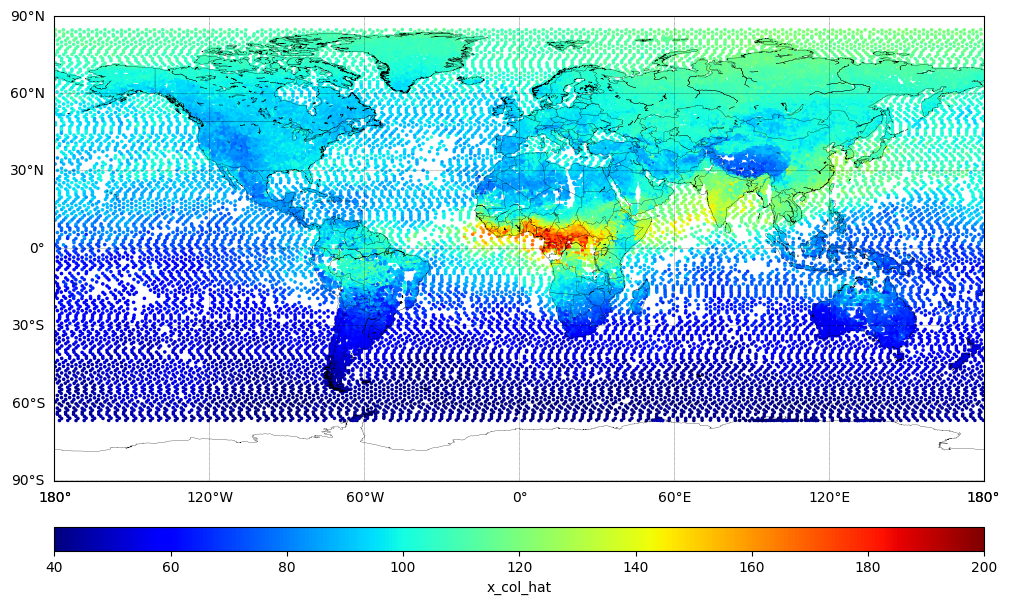

In [24]:
# Specify figure size (in inches)
fig = plt.figure(figsize=(12, 8))  

m = Basemap(projection='cyl', resolution='l', 
            llcrnrlat=-90, urcrnrlat=90,  # set latitude limits to -90 and 90
            llcrnrlon=-180, urcrnrlon=180)  # set longitude limits to -180 and 180

m.drawcoastlines(linewidth=0.2)
m.drawcountries(linewidth=0.2)

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = np.arange(-90., 91., 30.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

meridians = np.arange(-180., 181., 60.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3)    

# Standard catter plot
# Transform lat and lon to map projection coordinates
xlon, ylat = m(longitude, latitude)

# Plot the data using scatter (you may want to choose a different colormap and normalization)
sc = m.scatter(xlon, ylat, c=x_col_hat, cmap='jet', s=10, vmin=40.0, vmax=200.0, marker='.')

# Add a colorbar
cbar = m.colorbar(sc, location='bottom', pad="10%")
cbar.set_label('x_col_hat')

plt.show()

## Plot Difference (Predicted - True)

Plot the percentage difference between TROPESS XCO (Truth) and SEARS XCO CrIS ML v1.9 (Predicted):   

# of observations: 40470


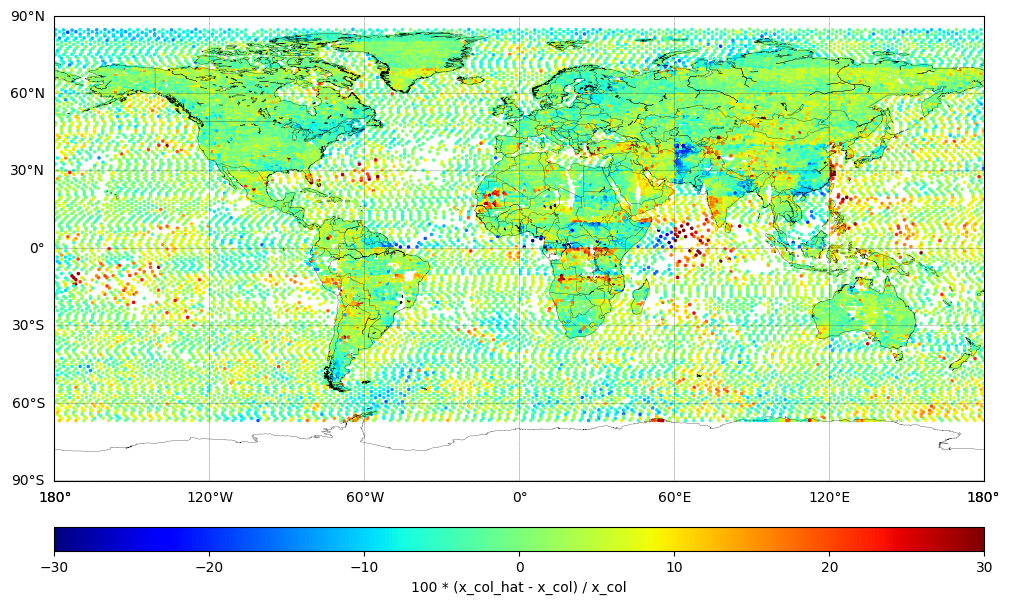

In [25]:
ydiff = 100 * (x_col_hat - x_col) / x_col
print (f'# of observations: {len(ydiff)}')

# Specify figure size (in inches)
fig = plt.figure(figsize=(12, 8))  

m = Basemap(projection='cyl', resolution='l', 
            llcrnrlat=-90, urcrnrlat=90,  # set latitude limits to -90 and 90
            llcrnrlon=-180, urcrnrlon=180)  # set longitude limits to -180 and 180

m.drawcoastlines(linewidth=0.2)
m.drawcountries(linewidth=0.2)

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = np.arange(-90., 91., 30.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

meridians = np.arange(-180., 181., 60.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3)    

# Standard catter plot
# Transform lat and lon to map projection coordinates
xlon, ylat = m(longitude, latitude)

# Plot the data using scatter (you may want to choose a different colormap and normalization)
sc = m.scatter(xlon, ylat, c=ydiff, cmap='jet', s=10, vmin=-30.0, vmax=+30.0, marker='.')

# Add a colorbar
cbar = m.colorbar(sc, location='bottom', pad="10%")
cbar.set_label('100 * (x_col_hat - x_col) / x_col')

plt.show()

## Plot Difference (less than 10%)

Plot the percentage difference between the TROPESS XCO (Truth) and the SEARS XCO CrIS ML v1.9 (Predicted) where the difference is less than 10%:    

# of observations: 40470
# of observations where difference < 10%: 37666


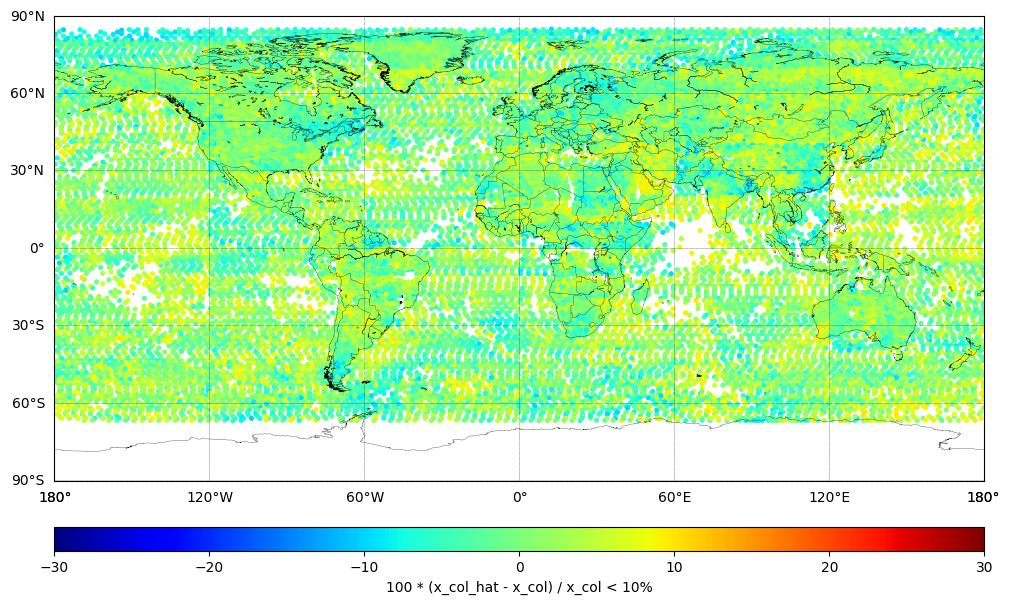

In [26]:
ydiff = 100 * (x_col_hat - x_col) / x_col
print (f'# of observations: {len(ydiff)}')

ydiff_10_index = np.where(abs(ydiff) < 10)[0]
ydiff_10 = ydiff[ydiff_10_index]
print (f'# of observations where difference < 10%: {len(ydiff_10)}')

latitude_10 = latitude[ydiff_10_index]
longitude_10 = longitude[ydiff_10_index]

# Specify figure size (in inches)
fig = plt.figure(figsize=(12, 8))  

m = Basemap(projection='cyl', resolution='l', 
            llcrnrlat=-90, urcrnrlat=90,  # set latitude limits to -90 and 90
            llcrnrlon=-180, urcrnrlon=180)  # set longitude limits to -180 and 180

m.drawcoastlines(linewidth=0.2)
m.drawcountries(linewidth=0.2)

# Draw parallels (latitude lines) and meridians (longitude lines)
parallels = np.arange(-90., 91., 30.)
m.drawparallels(parallels, labels=[True,False,False,False], linewidth=0.3)

meridians = np.arange(-180., 181., 60.)
m.drawmeridians(meridians, labels=[False,False,False,True], linewidth=0.3)    

# Standard catter plot
# Transform lat and lon to map projection coordinates
xlon, ylat = m(longitude_10, latitude_10)

# Plot the data using scatter (you may want to choose a different colormap and normalization)
sc = m.scatter(xlon, ylat, c=ydiff_10, cmap='jet', s=30, vmin=-30.0, vmax=+30.0, marker='.')

# Add a colorbar
cbar = m.colorbar(sc, location='bottom', pad="10%")
cbar.set_label('100 * (x_col_hat - x_col) / x_col < 10%')

plt.show()